In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
import requests
from pathlib import Path

if Path('names.txt').exists():
    words = open('names.txt', 'r').read().splitlines()
else:
    req = requests.get(r'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt')
    
    with open('names.txt', 'wb') as f:
        f.write(req.content)
    words = open('names.txt','r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> e
..e --> b
.eb --> r
ebr --> i
bri --> m
rim --> a
ima --> .
... --> h
..h --> i
.hi --> l
hil --> t
ilt --> o
lto --> n
ton --> .
... --> j
..j --> h
.jh --> e
jhe --> n
hen --> e
ene --> .


In [21]:
x = torch.randint(1,10, (2,2,3,3))
x

tensor([[[[9, 5, 7],
          [6, 2, 9],
          [6, 1, 3]],

         [[5, 8, 4],
          [4, 3, 5],
          [8, 3, 1]]],


        [[[2, 7, 9],
          [5, 1, 6],
          [3, 5, 7]],

         [[8, 9, 5],
          [9, 4, 2],
          [5, 2, 2]]]])

In [23]:
x.sum(0, keepdim=True), x.sum(1)

(tensor([[[[11, 12, 16],
           [11,  3, 15],
           [ 9,  6, 10]],
 
          [[13, 17,  9],
           [13,  7,  7],
           [13,  5,  3]]]]),
 tensor([[[14, 13, 11],
          [10,  5, 14],
          [14,  4,  4]],
 
         [[10, 16, 14],
          [14,  5,  8],
          [ 8,  7,  9]]]))

In [7]:
#Near Copy paste of part 3 notebook

#Linear Layer
class Linear:
    def __init__(self,
                fan_in: int,
                fan_out: int,
                bias = True):
        
        self.weight = torch.randn((fan_in, fan_out)) // fan_in ** 0.5  #note kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,
               x:torch.Tensor):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#Batch Normalisation Layer

class BatchNorm1d:

    def __init__(self,
                dim: int,
                eps: int|float = 1e-5,
                momentum: int|float = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self,
                x: torch.Tensor):

        #calculate the forward pass
        if self.training:
            xmean = x.mean(0,keepdims= True)
            xvar = x.var(0, keepdims = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) /torch.sqrt(xvar + self.eps) #normalise to unit variance
        self.out = self.gamma * xhat + self.beta

        #Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

#Activation Layer
class Tanh:
    def __call__(self,
                 x:torch.Tensor):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
        
    
        

In [30]:
Xtr[1]

tensor([ 0,  0, 25])

In [57]:
c = torch.randn(27, 10)
c[Xtr[[1,2]]], c[Xtr[1]], c[Xtr[[1,2]]].view(2, -1)

(tensor([[[-1.8347,  1.3372,  0.0435,  0.9037, -2.3000, -1.8546, -0.3708,
            0.8617, -0.0815, -0.5283],
          [-1.8347,  1.3372,  0.0435,  0.9037, -2.3000, -1.8546, -0.3708,
            0.8617, -0.0815, -0.5283],
          [-1.8072,  0.1095, -1.2750, -2.9810, -0.6617, -0.9872,  0.7357,
           -1.1467, -0.2426, -0.3318]],
 
         [[-1.8347,  1.3372,  0.0435,  0.9037, -2.3000, -1.8546, -0.3708,
            0.8617, -0.0815, -0.5283],
          [-1.8072,  0.1095, -1.2750, -2.9810, -0.6617, -0.9872,  0.7357,
           -1.1467, -0.2426, -0.3318],
          [-0.2959,  1.2889,  0.0446,  0.9098, -0.0984, -1.0908, -1.2545,
            0.6205, -0.6505, -0.6958]]]),
 tensor([[-1.8347,  1.3372,  0.0435,  0.9037, -2.3000, -1.8546, -0.3708,  0.8617,
          -0.0815, -0.5283],
         [-1.8347,  1.3372,  0.0435,  0.9037, -2.3000, -1.8546, -0.3708,  0.8617,
          -0.0815, -0.5283],
         [-1.8072,  0.1095, -1.2750, -2.9810, -0.6617, -0.9872,  0.7357, -1.1467,
          -0

In [37]:
c[Xtr[1]].shape

torch.Size([3, 10])

In [52]:
for i in Xtr[1]:
    print(itos[i.item()])

.
.
e


In [8]:
torch.manual_seed(42)

In [9]:
n_embd = 10
n_hidden = 200
C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(fan_in= block_size * n_embd,
          fan_out= n_hidden,
          bias = False), BatchNorm1d(dim = n_hidden), Tanh(),
    Linear(fan_in = n_hidden,
          fan_out = vocab_size)
]

#Parameter init

with torch.no_grad():
    layers[-1].weight *= 0.1  #last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [10]:
# Same Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed the characters into the vectors 
    x = emb.view(Xb.shape[0], -1)
    
    for layer in layers:        
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3517
  10000/ 200000: 2.3907
  20000/ 200000: 2.4897
  30000/ 200000: 2.3136
  40000/ 200000: 2.3068
  50000/ 200000: 2.6146
  60000/ 200000: 2.5422
  70000/ 200000: 1.8522
  80000/ 200000: 1.8862
  90000/ 200000: 1.7571
 100000/ 200000: 2.4206
 110000/ 200000: 2.1336
 120000/ 200000: 2.1542
 130000/ 200000: 2.0834
 140000/ 200000: 2.4366
 150000/ 200000: 2.1078
 160000/ 200000: 1.9967
 170000/ 200000: 2.2503
 180000/ 200000: 2.1931
 190000/ 200000: 1.9876


In [79]:
Xtr[torch.randint(0, Xtr.shape[0], (batch_size,))].shape

torch.Size([32, 3])

In [81]:
C[Xtr[torch.randint(0, Xtr.shape[0], (batch_size,))]].shape

torch.Size([32, 3, 10])

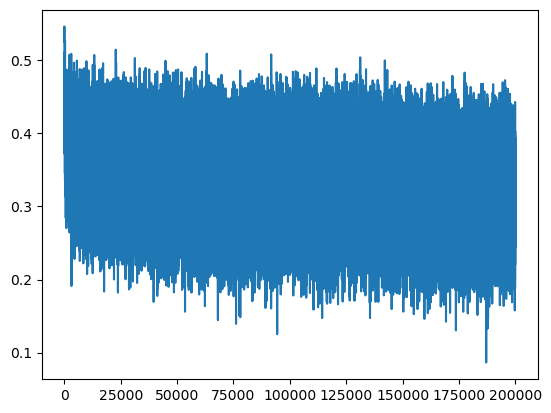

In [11]:
plt.plot(lossi)

In [12]:
#Put the layers into eval mode
for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

In [13]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0801782608032227
val 2.1198549270629883


In [14]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

damiara.
alka.
aris.
tri.
gerryslyn.
sayvo.
ceino.
sot.
emon.
cani.
ciaub.
alitithira.
liza.
jeman.
ana.
alynna.
jamaur.
ben.
quan.
torie.


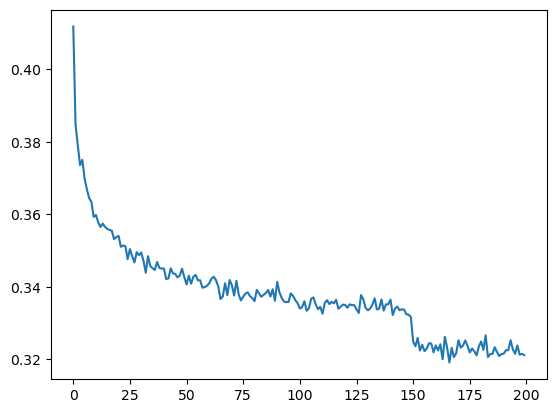

In [15]:
#Re structure the loss plot 
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [19]:
# Module for Embedding

class Embedding:

    def __init__(self, 
                num_embeddings: int,
                embedding_dim: int):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, 
                 IX:torch.Tensor):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#Module for Flatten
class Flatten:

    def __call__(self,
                x: torch.Tensor):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


#Module for Sequential

class Sequential:

    def __init__(self,
                layers:list):
        self.layers = layers
    
    def __call__(self, 
                x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [22]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(num_embeddings = vocab_size,
             embedding_dim = n_embd),
    Flatten(),
    Linear(n_embd * block_size,
          n_hidden,
          bias = False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden,
          vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [24]:
# Same Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3569


In [29]:
#Re structure the loss plot 
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 1

In [26]:
#Put the layers into eval mode
for layer in model.layers:
    layer.training = False

In [27]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.383620500564575
val 3.380610466003418


In [28]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

bakgsjpyqykqbnhkijitgeuoeemznsuhgpuullhfo.
qorhas.
bacpadsczcotsbicah.
hdt.
vkijcqjpnh.
arnuygbtseeslljqxjonrjoezomorrbham.
vqwmmxudpjcgzjlnvucemnzyqyskguictznwhalsyukliqgrrrzhtry.
bjrbuekdfenshpxrpscappxrozjnpwwaxtvgigrbctxrvlbnzrzvz.
lnziuelesumczj.
nafhndxgth.
ikcylizpzdpsjxjefasvl.
ikowsstqxjvcorrw.
mgwlchoxblfiywkliijxkfzlh.
tmerbuuklievkkxjkfabprucmdur.
qqeliwjkhqhclkunxyiafqmthxthkhrqyhug.
orcutnlycxptk.
aixlpzzxyyswzwuxefauilculs.
kqyszmz.
ztpl.
t.


# Implementing Wavenet

In [45]:
from tqdm import tqdm

In [100]:
# build the dataset
block_size = 16 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182441, 16]) torch.Size([182441])
torch.Size([22902, 16]) torch.Size([22902])
torch.Size([22803, 16]) torch.Size([22803])


In [101]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

................ --> e
...............e --> l
..............el --> i
.............eli --> a
............elia --> n
...........elian --> y
..........eliany --> s
.........elianys --> .
................ --> t
...............t --> r
..............tr --> o
.............tro --> y
............troy --> .
................ --> m
...............m --> a
..............ma --> r
.............mar --> k
............mark --> u
...........marku --> s
..........markus --> .


In [40]:
# for batch of 4, 8 is block size and 10 is embedding dims
#wavenet architecture is to take the inputs in sub groups 
print(torch.randn((4,8,10)).shape,' | ',torch.randn((4,8,10)).view(4,80).shape)

# if we want to take two inputs at a time we can group them as 
print(torch.randn((4,8,10)).view(4,-1,20).shape)
#the four in the dimension 1 (index starts from 0) holds two character per group hence has 20 dims where 10 for each charcter
torch.randn((4,8,10)).view(4,-1,20)[0]

torch.Size([4, 8, 10])  |  torch.Size([4, 80])
torch.Size([4, 4, 20])


tensor([[ 0.3839,  0.7760, -1.1590, -1.1825,  0.1536,  2.3877,  0.4820, -1.1294,
          0.6352, -0.4515, -0.8486, -0.2286, -0.8888, -1.5146,  0.0213, -1.9360,
         -0.3061,  0.1917, -2.0027, -1.8365],
        [ 0.4488, -0.6486,  0.3250, -0.0257, -0.3038, -1.5819, -0.1326, -0.3774,
          1.2290,  2.4783, -1.7748, -1.1239, -1.2347, -0.1523,  0.8574, -0.6728,
          0.6395, -0.1067,  0.9066, -1.0997],
        [-0.0986, -1.1156,  0.4401, -1.1528,  1.4821,  0.5700, -1.8380, -0.9553,
         -0.4530, -0.9762, -0.4446,  0.1068,  0.6261, -0.3136,  0.8145,  0.7461,
          0.5240,  0.1876, -0.3898,  1.0543],
        [ 0.6951,  0.2021, -0.5752, -0.3475,  0.6412, -0.1004, -0.6735,  1.8050,
         -0.8052, -1.5130,  1.8885,  1.0273,  0.4233,  0.0616,  1.5087, -0.2803,
         -1.1856, -0.1599, -0.7874, -0.1946]])

In [119]:
#Near Copy paste of part 3 notebook

#Linear Layer
class Linear:
    def __init__(self,
                fan_in: int,
                fan_out: int,
                bias = True):
        
        self.weight = torch.randn((fan_in, fan_out)) // fan_in ** 0.5  #note kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,
               x:torch.Tensor):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#Batch Normalisation Layer

class BatchNorm1d:

    def __init__(self,
                dim: int,
                eps: int|float = 1e-5,
                momentum: int|float = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self,
                x: torch.Tensor):

        #calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim,keepdims= True)
            xvar = x.var(dim, keepdims = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) /torch.sqrt(xvar + self.eps) #normalise to unit variance
        self.out = self.gamma * xhat + self.beta

        #Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

#Activation Layer
class Tanh:
    def __call__(self,
                 x:torch.Tensor):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# Module for Embedding

class Embedding:

    def __init__(self, 
                num_embeddings: int,
                embedding_dim: int):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, 
                 IX:torch.Tensor):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#Module for Flatten
class FlattenConsecutive:

    def __init__(self,
                n : int):
        self.n = n

    def __call__(self,
                x: torch.Tensor):
        B,T,C = x.size()
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
        
    def parameters(self):
        return []


#Module for Sequential

class Sequential:

    def __init__(self,
                layers:list):
        self.layers = layers
    
    def __call__(self, 
                x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        


In [120]:
torch.manual_seed(42); # seed rng for reproducibility

In [121]:
n_embd = 100
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias= False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

289727


In [118]:
for layer in model.layers:
    print(f'{layer.__class__.__name__} of shape {layer.out.shape}')

Embedding of shape torch.Size([32, 16, 40])
FlattenConsecutive of shape torch.Size([32, 8, 80])
Linear of shape torch.Size([32, 8, 200])
BatchNorm1d of shape torch.Size([32, 8, 200])
Tanh of shape torch.Size([32, 8, 200])
FlattenConsecutive of shape torch.Size([32, 4, 400])
Linear of shape torch.Size([32, 4, 200])
BatchNorm1d of shape torch.Size([32, 4, 200])
Tanh of shape torch.Size([32, 4, 200])
FlattenConsecutive of shape torch.Size([32, 2, 400])
Linear of shape torch.Size([32, 2, 200])
BatchNorm1d of shape torch.Size([32, 2, 200])
Tanh of shape torch.Size([32, 2, 200])
FlattenConsecutive of shape torch.Size([32, 400])
Linear of shape torch.Size([32, 200])
BatchNorm1d of shape torch.Size([32, 200])
Tanh of shape torch.Size([32, 200])
Linear of shape torch.Size([32, 27])


In [122]:
# Same Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in tqdm(range(max_steps)):

    #minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    # print(logits)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update : simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

    

  0%|                                                                             | 24/200000 [00:00<27:22, 121.78it/s]

      0/ 200000: 3.4586


  5%|███▋                                                                      | 10016/200000 [01:30<29:11, 108.50it/s]

  10000/ 200000: 2.7541


 10%|███████▌                                                                   | 20013/200000 [03:11<32:59, 90.91it/s]

  20000/ 200000: 2.8033


 15%|███████████▎                                                               | 30019/200000 [05:01<30:28, 92.95it/s]

  30000/ 200000: 2.8691


 20%|██████████████▊                                                           | 40016/200000 [06:44<25:42, 103.74it/s]

  40000/ 200000: 2.8860


 25%|██████████████████▊                                                        | 50016/200000 [08:30<28:10, 88.73it/s]

  50000/ 200000: 2.8101


 30%|██████████████████████▌                                                    | 60016/200000 [10:17<25:25, 91.73it/s]

  60000/ 200000: 2.8545


 35%|██████████████████████████▎                                                | 70014/200000 [12:02<22:51, 94.79it/s]

  70000/ 200000: 2.7294


 40%|█████████████████████████████▌                                            | 80011/200000 [13:45<19:37, 101.86it/s]

  80000/ 200000: 2.5787


 45%|█████████████████████████████████▊                                         | 90016/200000 [15:32<25:08, 72.91it/s]

  90000/ 200000: 2.5820


 50%|█████████████████████████████████████                                     | 100018/200000 [17:20<17:37, 94.55it/s]

 100000/ 200000: 2.6897


 55%|████████████████████████████████████████▋                                 | 110015/200000 [19:32<17:19, 86.58it/s]

 110000/ 200000: 2.5075


 60%|████████████████████████████████████████████▍                             | 120011/200000 [21:51<19:07, 69.73it/s]

 120000/ 200000: 2.4698


 65%|████████████████████████████████████████████████                          | 130010/200000 [23:52<20:23, 57.21it/s]

 130000/ 200000: 2.5207


 70%|███████████████████████████████████████████████████▊                      | 140011/200000 [26:12<14:18, 69.85it/s]

 140000/ 200000: 2.3907


 75%|██████████████████████████████████████████████████████▊                  | 150018/200000 [28:11<07:53, 105.65it/s]

 150000/ 200000: 2.6604


 80%|███████████████████████████████████████████████████████████▏              | 160014/200000 [30:23<09:40, 68.86it/s]

 160000/ 200000: 2.6632


 85%|██████████████████████████████████████████████████████████████▉           | 170018/200000 [32:39<06:06, 81.82it/s]

 170000/ 200000: 2.4682


 90%|█████████████████████████████████████████████████████████████████▋       | 180020/200000 [34:31<03:07, 106.41it/s]

 180000/ 200000: 2.6600


 95%|██████████████████████████████████████████████████████████████████████▎   | 190012/200000 [36:31<02:03, 81.06it/s]

 190000/ 200000: 2.5132


100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [38:21<00:00, 86.91it/s]


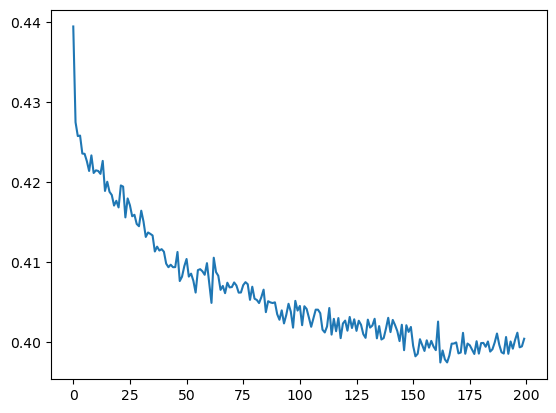

In [123]:
#Re structure the loss plot 
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [124]:
#Put the layers into eval mode
for layer in model.layers:
    layer.training = False

In [125]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.4970078468322754
val 2.496837854385376


In [127]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

nya.
aielly.
niele.
ahxo.
cavrwulbk.
tarui.
harawy.
kymein.
siaity.
aiyy.
sihieana.
ltahlonh.
asrainaa.
cawufei.
qenlie.
raiir.
khdlsrraa.
rirrene.
kydehvua.
pidrin.


In [129]:
torch.randn((4,3,*(3,3)))

tensor([[[[-2.4809e-01, -1.0346e+00, -1.5913e+00],
          [-1.0980e+00,  9.5245e-01, -2.8218e-01],
          [-2.9926e-02, -1.2037e-01, -2.8961e-01]],

         [[ 4.7051e-02, -7.4587e-01, -1.2899e+00],
          [ 7.0666e-01, -5.3342e-01,  8.0151e-01],
          [ 6.7092e-01, -2.3330e-01, -7.2014e-01]],

         [[ 1.8801e+00, -1.7427e+00, -5.2389e-01],
          [-8.6184e-01, -4.9184e-01,  2.6504e-01],
          [-1.6664e+00,  2.8618e-01, -1.3475e-01]]],


        [[[ 5.0617e-01, -1.1608e+00,  8.9839e-02],
          [-5.4900e-02,  1.1302e+00, -1.8118e+00],
          [ 1.4833e+00,  4.0350e-01,  1.7933e-01]],

         [[ 2.1271e-01, -1.5149e+00, -9.4919e-01],
          [ 2.8658e-01, -4.4932e-02,  1.5187e+00],
          [-4.7133e-01,  4.3978e-01, -7.9969e-01]],

         [[ 9.4450e-01,  6.0259e-01, -1.2550e+00],
          [-1.0209e+00,  3.4566e-01, -9.8983e-01],
          [-5.6235e-01,  1.0105e+00,  7.9711e-01]]],


        [[[-6.5405e-01, -2.7754e-01,  7.1123e-01],
          [ 6.9